# Home Credit Default Risk Analysis 
*Dimitar Vlassarev 2018*

# Imports and Data Loading

## Load Libraries

In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
class dataset(object):
    """A dataset class that will take the data and do pre-processing and in some cases
    modeling of the data. Instance variable data will hold a Pandas dataframe.
    
        @param path (str): String to the csv file (can be zipped) to load.
        @param exclude (list): Columns that should not be normalized or imputed.
        @param target (str): Column that is the target variable."""
    
    def __init__(self, path, exclude, target):
        """Loads data."""
        self.data = pd.read_csv(path)
        self.exclude = exclude
        self.target = target
        self.feature_columns = [col for col in self.data.columns 
                                if col not in (exclude + [target])]
        self.categorical_columns = self.data[self.feature_columns].select_dtypes([np.object]).columns
    
    def _clean_col_name(self, name):
        """Cleans column names from special characters and whitespaces.
            @param name (str): Input name.
            @return name (str): Cleaned up name."""

        name = name.upper()
        for c in ", /:":
            name = name.replace(c, "_")
        return(name)
    
    def describe_cardinality(self):
        """Prints the number of levels in each categorical column."""
        for col_name in self.categorical_columns:
            col_data = self.data[col_name]
            print("{:28s} has {:2d} levels.".format(col_name, len(col_data.unique())))

    def onehot(self):
        """Inplace, onehot encodes all the columns in the dataset.
            @param data (pandas.DataFrame): Data to encode."""  
        for col_name in self.categorical_columns:
            dummy_cols = pd.get_dummies(self.data[col_name])
            dummy_cols.columns = ["{}_{}".format(col_name, self._clean_col_name(dummy_name)) 
                                  for dummy_name in dummy_cols]
            data = self.data.merge(
                dummy_cols,
                left_index=True,
                right_index=True)
            self.data = self.data.drop(col_name, axis=1)
        self.feature_columns = [col for col in self.data.columns 
                                if col not in (self.exclude + [self.target])]
    
    def split_X_y(self):
        """Splits data columns into feature and target sets."""
        self.X = self.data[self.feature_columns]
        self.y = self.data[self.target]
    
    def impute(self, data, mode="fit_transform"):
        """Inplace, impute all columns with averages.
            @param data (pandas.DataFrame): Input to fit and tranform.
            @return data (pandas.DataFrame): Imputed data."""
        if mode in ["fit_transform", "fit"]:
            self.imp = Imputer().fit(data)
        if mode in ["fit_transform", "transform"]:
            return(pd.DataFrame(self.imp.transform(data), columns=data.columns))
        
    def standardize(self, data, mode="fit_transform"):
        """Inplace, mean and std normalizes all columns except exclude.
            @param data (pandas.DataFrame): Input to fit and tranform.
            @return data (pandas.DataFrame): Standardized data."""
        if mode in ["fit_transform", "fit"]:
            self.standard = StandardScaler().fit(data)
        if mode in ["fit_transform", "transform"]:
            return(pd.DataFrame(self.standard.transform(data), columns=data.columns))
    
    def split_train_test(self):
        "Splits feature and target data sets into test and train."
        data = train_test_split(self.X, self.y, test_size=0.20, random_state=757)
        X_train, X_test, y_train, y_test = data
    
    def pca_explore(self, n_components=None):
        """Runs PCA on the data and explores the number of components needed.
            @param n_components (int): Number of max components to consider."""
        df = self.X.copy()
        if not n_components:
            n_components = df.shape[1]
        pca = PCA(n_components=n_components)
        self.pca_model = pca.fit(df)
        self.data_pca = self.pca_model.transform(df)
        matplotlib.rcParams.update({'font.size': 16})
        plt.figure(figsize=(16, 9))
        plt.plot(range(1, n_components + 1), 
                 np.cumsum(pca.explained_variance_ratio_),
                linewidth=3, alpha=0.7, color="r")
        plt.title("Variance Explained vs Number of Components")
        plt.xlabel("Number of principal components")
        plt.ylabel("Relative variance explained")
        plt.ylim((0, 1.01))
        plt.grid(alpha=0.5)

In [51]:
application = dataset(r"data/application_train.csv.zip", ["SK_ID_CURR"], "TARGET")

NAME_CONTRACT_TYPE           has  2 levels.
CODE_GENDER                  has  3 levels.
FLAG_OWN_CAR                 has  2 levels.
FLAG_OWN_REALTY              has  2 levels.
NAME_TYPE_SUITE              has  8 levels.
NAME_INCOME_TYPE             has  8 levels.
NAME_EDUCATION_TYPE          has  5 levels.
NAME_FAMILY_STATUS           has  6 levels.
NAME_HOUSING_TYPE            has  6 levels.
OCCUPATION_TYPE              has 19 levels.
WEEKDAY_APPR_PROCESS_START   has  7 levels.
ORGANIZATION_TYPE            has 58 levels.
FONDKAPREMONT_MODE           has  5 levels.
HOUSETYPE_MODE               has  4 levels.
WALLSMATERIAL_MODE           has  8 levels.
EMERGENCYSTATE_MODE          has  3 levels.


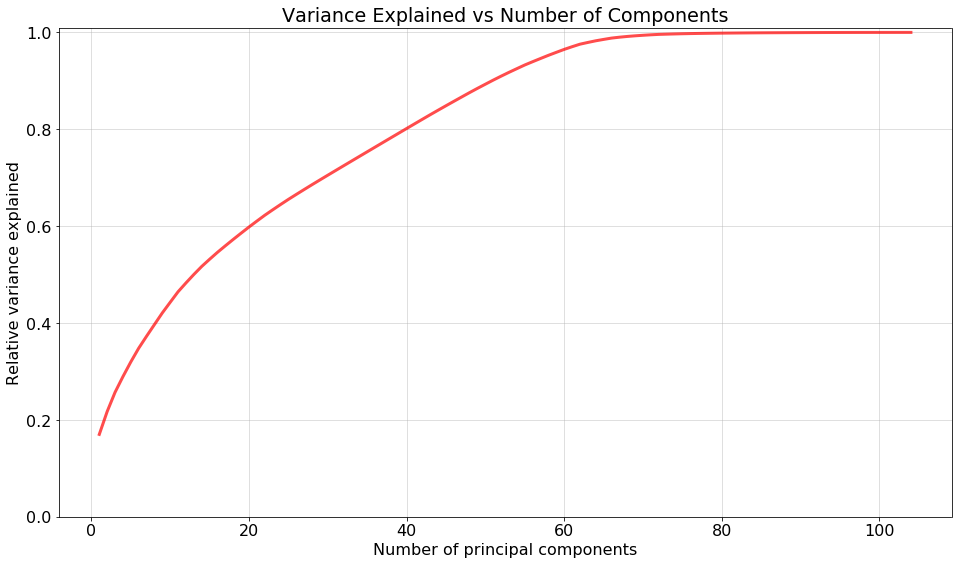

In [52]:
application.describe_cardinality()
application.onehot()
application.split_X_y()
application.X = application.impute(application.X)
application.X = application.standardize(application.X)
application.pca_explore()

In [53]:
application.X.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,...,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05,3.075110e+05
mean,-3.193704e-15,7.880806e-16,-9.238467e-17,1.302030e-16,3.266753e-16,4.659239e-16,3.710928e-17,-2.784011e-16,-5.944310e-18,7.987038e-17,...,3.762494e-15,4.450950e-15,4.986820e-15,-1.535583e-15,-2.530283e-15,-4.077037e-15,-9.146561e-15,-1.813542e-15,4.634362e-15,-3.327294e-15
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-5.775378e-01,-6.036870e-01,-1.376496e+00,-1.758940e+00,-1.348293e+00,-1.487798e+00,-2.106335e+00,-5.784940e-01,-5.588007e+00,-2.784328e+00,...,-9.053411e-02,-2.440195e-02,-2.252901e-02,-1.830463e-02,-8.210023e-02,-6.795715e-02,-1.805048e-01,-3.138730e-01,-3.594746e-01,-1.092866e+00
25%,-5.775378e-01,-2.374210e-01,-8.174760e-01,-7.303015e-01,-8.121132e-01,-7.853308e-01,-8.352476e-01,-4.712426e-01,-7.077673e-01,-8.644204e-01,...,-9.053411e-02,-2.440195e-02,-2.252901e-02,-1.830463e-02,-8.210023e-02,-6.795715e-02,-1.805048e-01,-3.138730e-01,-3.594746e-01,-5.176655e-01
50%,-5.775378e-01,-9.129414e-02,-2.124151e-01,-1.521775e-01,-2.393752e-01,-1.459095e-01,6.576450e-02,-4.602923e-01,1.368540e-01,-1.721143e-01,...,-9.053411e-02,-2.440195e-02,-2.252901e-02,-1.830463e-02,-8.210023e-02,-6.795715e-02,-1.805048e-01,-3.138730e-01,-3.594746e-01,-3.831603e-16
75%,8.072731e-01,1.421293e-01,5.208178e-01,5.166083e-01,3.821064e-01,5.635704e-01,8.304332e-01,-4.537519e-01,8.447974e-01,8.441512e-01,...,-9.053411e-02,-2.440195e-02,-2.252901e-02,-1.830463e-02,-8.210023e-02,-6.795715e-02,-1.805048e-01,0.000000e+00,-7.516682e-17,6.327349e-01
max,2.573387e+01,4.927034e+02,8.574059e+00,1.593252e+01,9.509356e+00,3.733564e+00,1.958761e+00,2.133617e+00,1.415353e+00,1.983641e+00,...,1.104556e+01,4.098034e+01,4.438721e+01,5.463098e+01,5.121092e+01,8.730290e+01,4.184385e+01,3.137918e+01,3.530567e+02,1.328714e+01


## Load Data

In [ ]:
# Load data into dataframes
application_train     = pd.read_csv(r"data/application_train.csv.zip")
# application_test      = pd.read_csv(r"data/application_test.csv.zip")
# bureau                = pd.read_csv(r"data/bureau.csv.zip")
# bureau_balance        = pd.read_csv(r"data/bureau_balance.csv.zip")
# credit_card_balance   = pd.read_csv(r"data/credit_card_balance.csv.zip")
# installments_payments = pd.read_csv(r"data/installments_payments.csv.zip")
# pos_cash_balance      = pd.read_csv(r"data/POS_CASH_balance.csv.zip")
# previous_application  = pd.read_csv(r"data/previous_application.csv.zip")
columns_description   = pd.read_csv(r"data/HomeCredit_columns_description.csv", encoding='cp1252')

## Display Column descriptions

In [ ]:
# Column descriptions
pd.options.display.max_rows = 500
display(columns_description[["Table", "Row", "Description", "Special"]])
pd.reset_option("max_rows")

In [ ]:
# Pick out string columns
cardinal_columns = application_train.select_dtypes([np.object]).columns
for col_name in cardinal_columns:
    col_data = application_train[col_name]
    print("{:28s} has {:2d} levels.".format(col_name, len(col_data.unique())))

# One-hot encode all the cardinal columns
def clean_col_name(name):
    """
        Cleans column names from special characters and whitespaces.
        @param name (str): Input name
        @return name (str): Cleaned up name
    """
    
    name = name.upper()
    name = name.replace(",", "_")
    name = name.replace(" ", "_")
    name = name.replace("/", "_")
    name = name.replace(":", "_")
    return(name)

for col_name in cardinal_columns:
    dummy_cols = pd.get_dummies(application_train[col_name])
    dummy_cols.columns = ["{}_{}".format(col_name, clean_col_name(dummy_name)) for dummy_name in dummy_cols]
              
    application_train = application_train.merge(
        dummy_cols,
        left_index=True,
        right_index=True)
    application_train = application_train.drop(col_name, axis=1)

In [ ]:
application_train.describe()

In [ ]:
for col in application_train.columns:
    print(col)

In [ ]:
# Target data appears to be all present and only contain 0 and 1 values
y = application_train["TARGET"].copy()

In [ ]:
application_train["EXT_SOURCE_1"].describe()

In [ ]:
application_train[["NAME_CONTRACT_TYPE"]].merge(
    pd.get_dummies(application_train["NAME_CONTRACT_TYPE"]),
    left_index=True,
    right_index=True)

In [ ]:
X = application_train[["CNT_CHILDREN", 
                  "AMT_INCOME_TOTAL",
                  "AMT_CREDIT",
                  "AMT_ANNUITY",
                  "AMT_GOODS_PRICE",
                  "DAYS_BIRTH",
                  "DAYS_EMPLOYED"]].copy()

In [ ]:
mask = X.isna().apply(lambda row: not any(row), axis=1)

In [ ]:
X = X[mask].values
y = y[mask].values

In [ ]:
pca = PCA(n_components=2)
pca_model = pca.fit(X)